<h1 style="font-family: Impact, Charcoal, sans-serif; padding: 12px; font-size: 30px; color: #8b4513; text-align: center; line-height: 1.25;">EXPAI Tecnical Test<br><span style="color: #800000; font-size: 48px"><b>Titanic Survival and Fare Predictions</b></span><br><span style="color: #a0522d; font-size: 20px">Binary Classification and Logistic Regression</span></h1>

<div style="display: flex; justify-content: center;">
  <img src="/Users/eo/src/data-ship-api/data/titanic.jpg" alt="Titanic"  style="width:200px;">
</div>

<p>Data source: <a href="https://www.kaggle.com/competitions/titanic/data">Titanic Dataset</a></p>


<h1><b><span style="color: #8b4513; font-size: 28px">TABLE OF CONTENTS</span></b></h1>

* [Exploratory Data Analysis](#1)
    * [Survival Prediction](#1.1)
    * [Fare Prediction](#1.2)
* [Data Preprocessing](#2)
* [Data Visualization](#3)
* [Building Model with Sklearn](#4)
    * [Make Predictions](#4.1)
    * [Prediction Interpretability using SHAP Values](#4.2)
* [Prediction](#5)

In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from utils import DataAnalyzer

In [2]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titleweight'] = 'bold'
sns.set_palette('muted')

<a id="1"></a>
<h1><b><span style="color: #8b4513; font-size: 28px">Exploratory Data Analysis Questions</span></b></h1>

In [3]:
# Load the train and test datasets
train_path = '/Users/eo/src/data-ship-api/data/train.csv'
test_path = '/Users/eo/src/data-ship-api/data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()
train_df = train_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)
test_df = test_df.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

train_df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"braund, mr. owen harris",male,22.0,1,0,a/5 21171,7.2500,NaN,s
1,2,1,1,"cumings, mrs. john bradley (florence briggs th...",female,38.0,1,0,pc 17599,71.2833,c85,c
2,3,1,3,"heikkinen, miss. laina",female,26.0,0,0,ston/o2. 3101282,7.9250,NaN,s
3,4,1,1,"futrelle, mrs. jacques heath (lily may peel)",female,35.0,1,0,113803,53.1000,c123,s
4,5,0,3,"allen, mr. william henry",male,35.0,0,0,373450,8.0500,NaN,s


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Features</b></h1>

- **survived:** 0 = No, 1 = Yes
- **pclass:** A proxy for socio-economic status (SES). 
1st = Upper
2nd = Middle
3rd = Lower
- **age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- **sibsp:** # of siblings / spouses aboard the Titanic. 
- **parch:** # of parents / children aboard the Titanic. Some children travelled only with a nanny, therefore parch=0 for them.
- **embarked:** Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

**Update columns names**

In order to understand better the columns names and that the names are more selfexplanatory, a rename will be done, also for some values it will be replaced it by the port name. 


In [4]:
train_df = train_df.rename(columns={'embarked': 'embarked_port'})
port_mapping = {'s': 'southampton', 'q': 'queenstown', 'c': 'cherbourg'}
train_df['embarked_port'] = train_df['embarked_port'].map(port_mapping)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    891 non-null    int64  
 1   survived       891 non-null    int64  
 2   pclass         891 non-null    int64  
 3   name           891 non-null    object 
 4   sex            891 non-null    object 
 5   age            714 non-null    float64
 6   sibsp          891 non-null    int64  
 7   parch          891 non-null    int64  
 8   ticket         891 non-null    object 
 9   fare           891 non-null    float64
 10  cabin          204 non-null    object 
 11  embarked_port  889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Drop column passenger id**

In [6]:
column_to_exclude = 'passengerid'
train_df.drop('passengerid', inplace=True, axis=1)

In [7]:
train_df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
print(f'Train dataset shape: {train_df.shape}')

Train dataset shape: (891, 11)


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Check missing values and unique values</b></h1>

In [9]:
display(DataAnalyzer.get_missing_values(train_df))

,Total Nulos,% Nulos
cabin,687,77.104377
age,177,19.865320
embarked_port,2,0.224467


In [10]:
print(f'Number of unique values in each column of the train dataset: {train_df.nunique()}')

Number of unique values in each column of the train dataset: survived           2
pclass             3
name             891
sex                2
age               88
sibsp              7
parch              7
ticket           681
fare             248
cabin            147
embarked_port      3
dtype: int64


<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Target Variable 'survived' Distribution</b></h1>

In [11]:
print(f'Target variable distribution:\n{train_df.survived.value_counts()}')
total_instances = train_df['survived'].count()
class_0_count = train_df['survived'].value_counts()[0]
class_1_count = train_df['survived'].value_counts()[1]

proportion_class_0 = class_0_count / total_instances
proportion_class_1 = class_1_count / total_instances

print(f'Proportion of class 0 (non-survivors): {proportion_class_0:.2f}')
print(f'Proportion of class 1 (survivors): {proportion_class_1:.2f}')

Target variable distribution:
0    549
1    342
Name: survived, dtype: int64
Proportion of class 0 (non-survivors): 0.62
Proportion of class 1 (survivors): 0.38


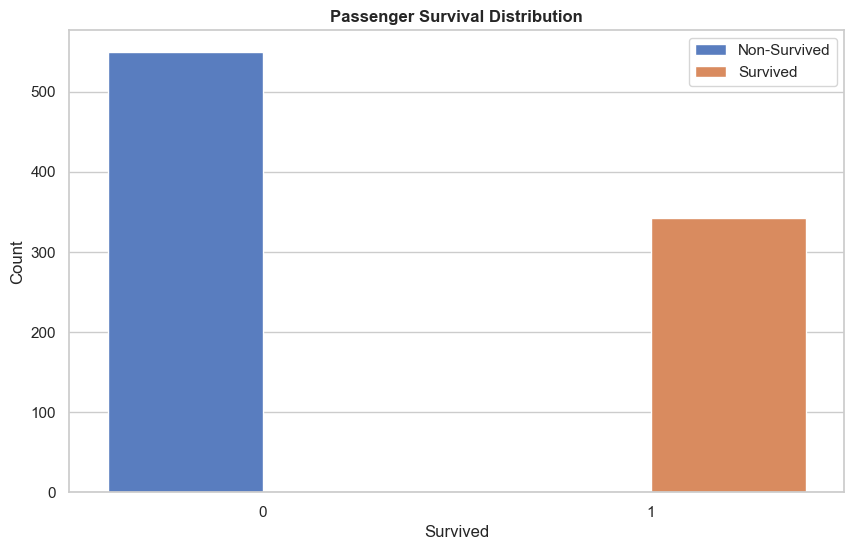

In [12]:
sns.countplot(x='survived', data=train_df, hue="survived")  
plt.xlabel('Survived')  
plt.ylabel('Count')  
plt.title('Passenger Survival Distribution')  
plt.legend(labels=['Non-Survived', 'Survived'])
plt.show()


In [13]:
print("Categorical feature distributions:")
print(train_df['sex'].value_counts())
print(train_df['pclass'].value_counts())
print(train_df['embarked_port'].value_counts())

Categorical feature distributions:
male      577
female    314
Name: sex, dtype: int64
3    491
1    216
2    184
Name: pclass, dtype: int64
southampton    644
cherbourg      168
queenstown      77
Name: embarked_port, dtype: int64


In [14]:
print("Outliers in 'Age':")
train_df[train_df['age'] > train_df['age'].mean() + 3 * train_df['age'].std()]

Outliers in 'Age':


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked_port
630,1,1,"barkworth, mr. algernon henry wilson",male,80.0,0,0,27042,30.000,a23,southampton
851,0,3,"svensson, mr. johan",male,74.0,0,0,347060,7.775,NaN,southampton


In [15]:
print("Outliers in 'Fare':")
fare_outliers = train_df[train_df['fare'] > train_df['fare'].mean() + 3 * train_df['fare'].std()]
fare_outliers[fare_outliers.fare>300]

Outliers in 'Fare':


,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked_port
258,1,1,"ward, miss. anna",female,35.0,0,0,pc 17755,512.3292,NaN,cherbourg
679,1,1,"cardeza, mr. thomas drake martinez",male,36.0,0,1,pc 17755,512.3292,b51 b53 b55,cherbourg
737,1,1,"lesurer, mr. gustave j",male,35.0,0,0,pc 17755,512.3292,b101,cherbourg


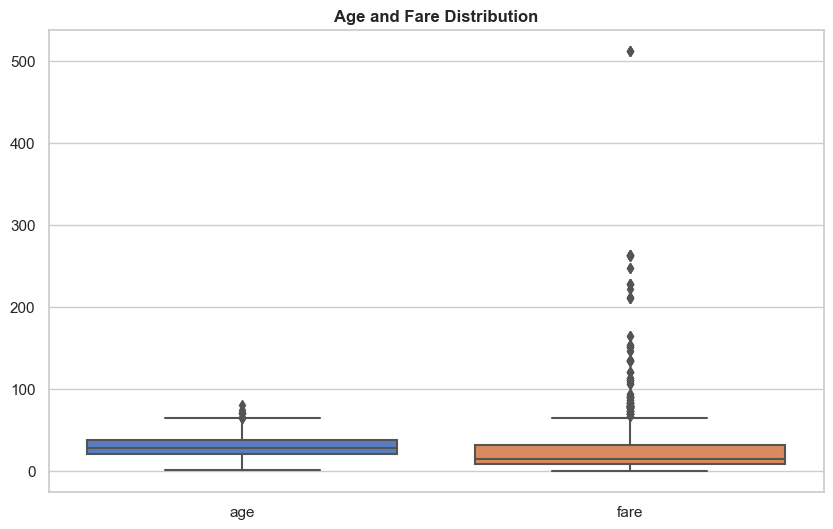

In [16]:
def plot_side_by_side_violin(data, title):
    sns.boxplot(data=data[["age", "fare"]], orient="v")
    plt.title(f'{title}')
    plt.show()

plot_side_by_side_violin(train_df, 'Age and Fare Distribution')


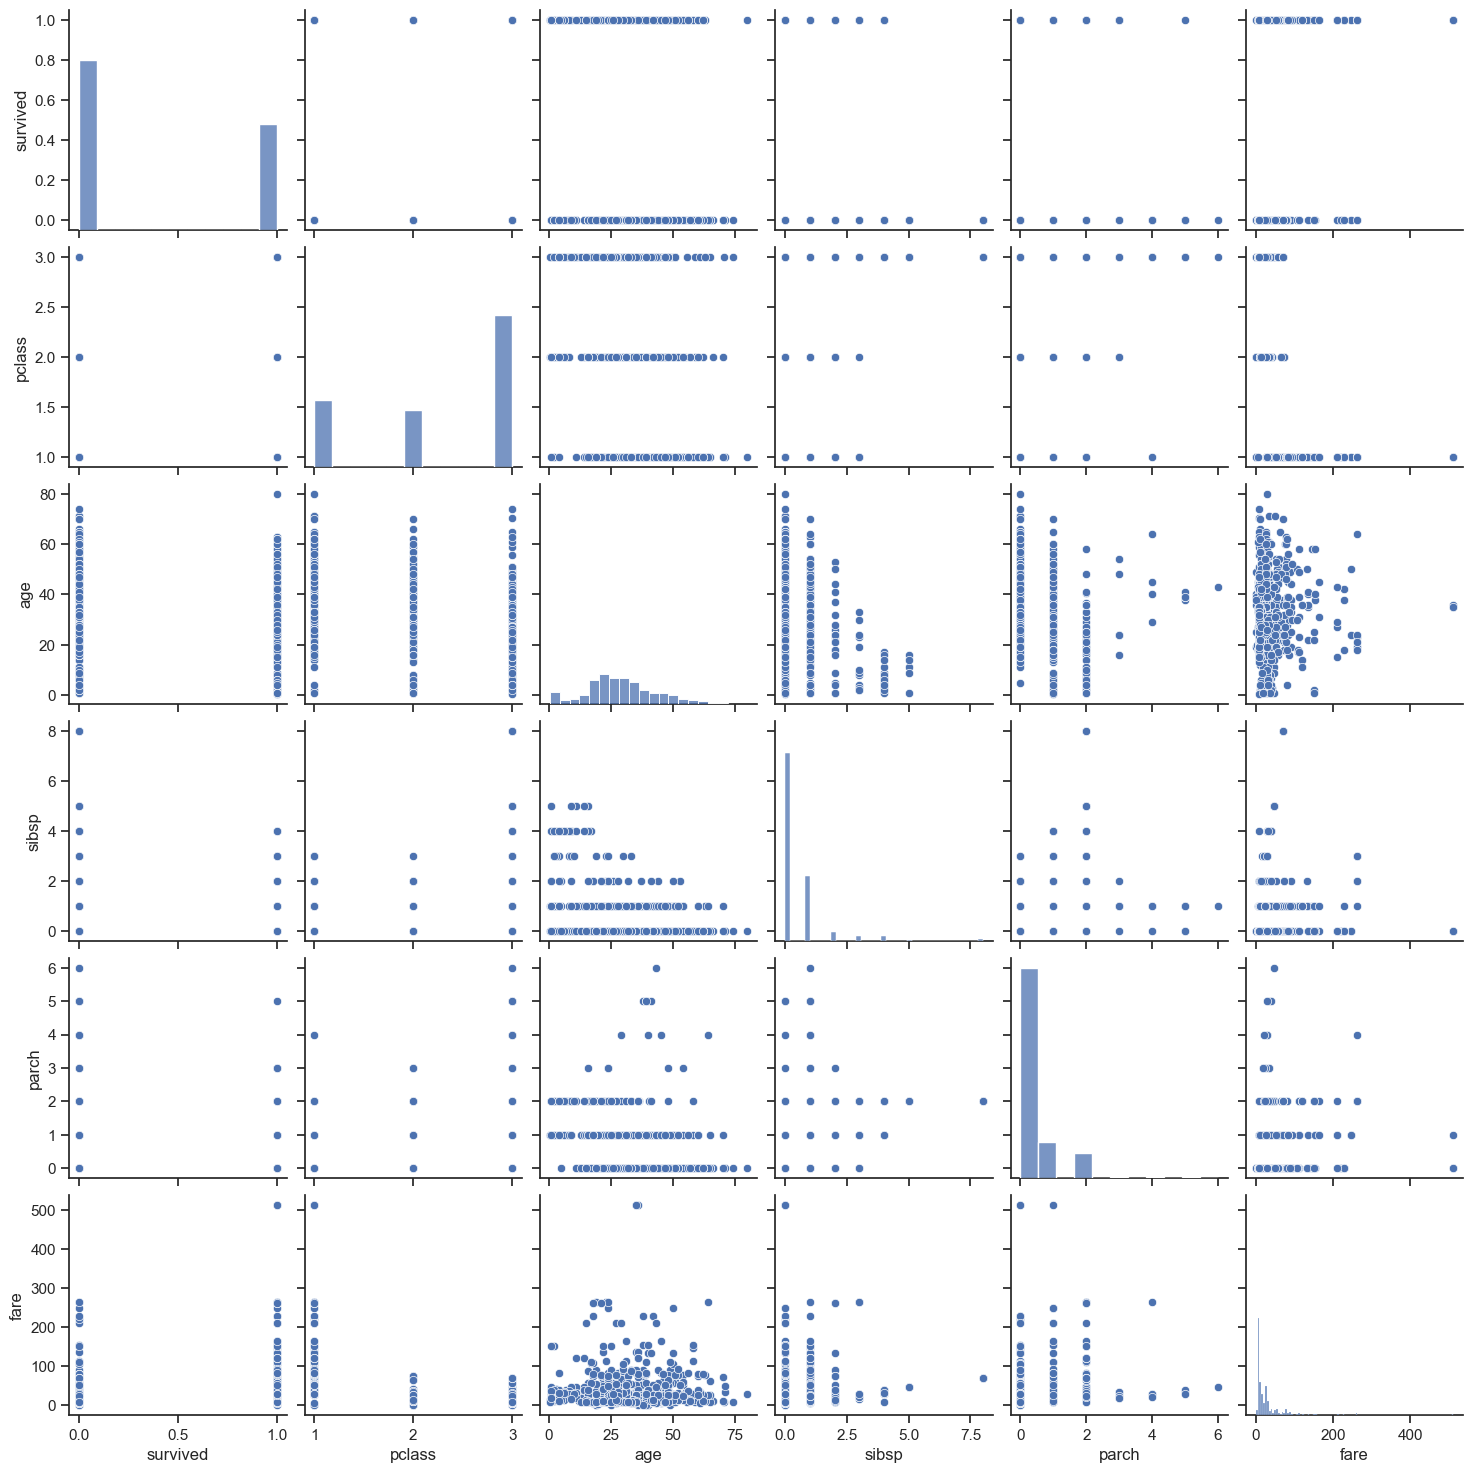

In [17]:
sns.set(style="ticks") 
sns.pairplot(train_df)
plt.show()

<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Initial Conclusions from Exploratory Data Analysis (EDA):</b></h1>

1. The train dataset contains 891 records and 12 columns, meaning it contains information about 891 passengers and various aspects related to them.

2. The 'cabin' column has a significant number of missing values, approximately 77% of the data is missing. This could be a challenge for our analysis and modeling since we have limited information about the cabins.

3. The 'age' column also has missing values, but the percentage is relatively lower, around 19.8%. We will need to handle these missing values thoughtfully to avoid bias in our analysis.

4. The 'embarked' column has only 2 missing values, which is a small proportion of the dataset. We can consider various strategies to deal with these missing values, such as imputation or excluding those rows.

5. The target variable is called 'survived', and it indicates whether a passenger survived (1) or not (0). The data is imbalanced with 62% of non-survivors and 38% of survivors. This imbalance might impact our model's performance, and we might need to use techniques like resampling or different evaluation metrics to handle it.

6. The mean survival rate is approximately 38.38%, indicating that about 38.38% of the passengers in the dataset survived the Titanic disaster.

7. The passengers' ages range from approximately 5 months (0.42 years) to 80 years old, with an average age of around 29.70 years.

8. On average, passengers tend to travel with few family members. The 'sibsp' column, representing the number of siblings and spouses aboard, has a mean value of 0.52, and the 'parch' column, representing the number of parents and children aboard, has a mean value of 0.38.

9. The average fare paid by passengers is approximately 32.20 units. However, some passengers received complimentary tickets or traveled for free, as indicated by the minimum fare of 0 units. On the other hand, some passengers paid significantly higher fares, with the maximum fare being 512.33 units.

***Additional Insights:***

10. Three passengers paid the highest fare of 512.33 units and survived the disaster. They were embarked at the port Cherbourg and belonged to the first class. Their ages were between 35 and 36 years old, and interestingly, most of them were traveling alone, except one passenger who had either a parent or child aboard.

<a id="1.1"></a>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Survival Prediction</b></h1>

#### **Survival by Class**
   - How does the passenger class (1st, 2nd, or 3rd) influence the survival rate?

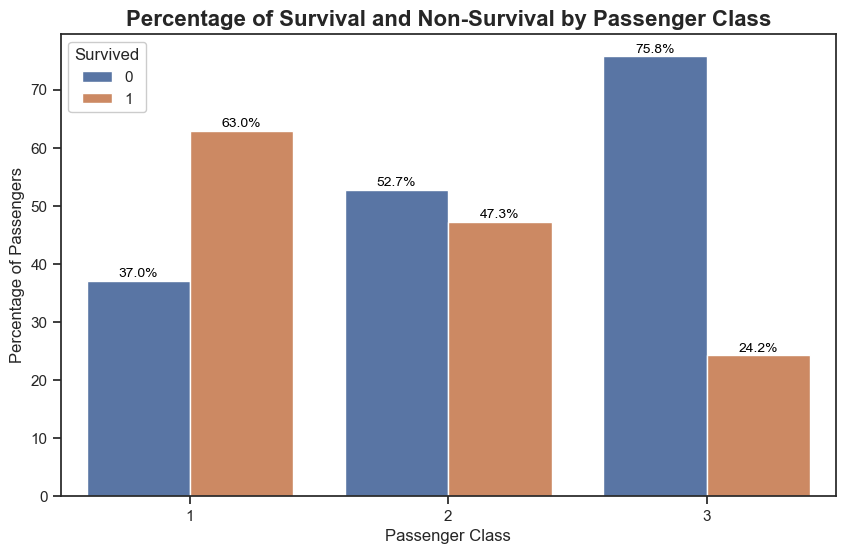

In [18]:
gr_data = DataAnalyzer.calculate_survival_percentage(train_df, 'pclass')
DataAnalyzer.plot_survival_by_feature(gr_data, 'pclass', 'Passenger Class','Percentage of Passengers', 'Percentage of Survival and Non-Survival by Passenger Class' )

##### **Based on the analysis of survival rate by passenger class, the following conclusions can be drawn:**

1. Passengers in the third class had the lowest survival rate among all three classes, with only 24.2% surviving the disaster. Despite constituting the majority of the passengers onboard, the survival rate is the lowest. 

2. On the other hand, first-class passengers had a much higher survival rate of 63%. Despite being a minority in terms of population onboard, they had a significantly higher chance of surviving the tragedy.

3. The second-class passengers had a survival rate of approximately 47%, which is only slightly higher than their not-survived rate of 52%. Their survival chances were more balanced compared to the other classes.

The analysis indicates that belonging to the first class increased the likelihood of survival. This might be attributed to the allocation of resources and priority during the evacuation process, with first-class passengers potentially having easier access to lifeboats and safety measures.

Overall, the data suggests a clear correlation between passenger class and survival rate. Passengers in the higher-class cabins, specifically the first class, had a significantly better chance of surviving the Titanic disaster compared to those in the lower-class cabins. This could be due to various factors, including location of the cabins, access to lifeboats, and preferential treatment during evacuation that will be analyzed further. 

#### **Survival by Gender**
   - What is the survival rate for males and females?

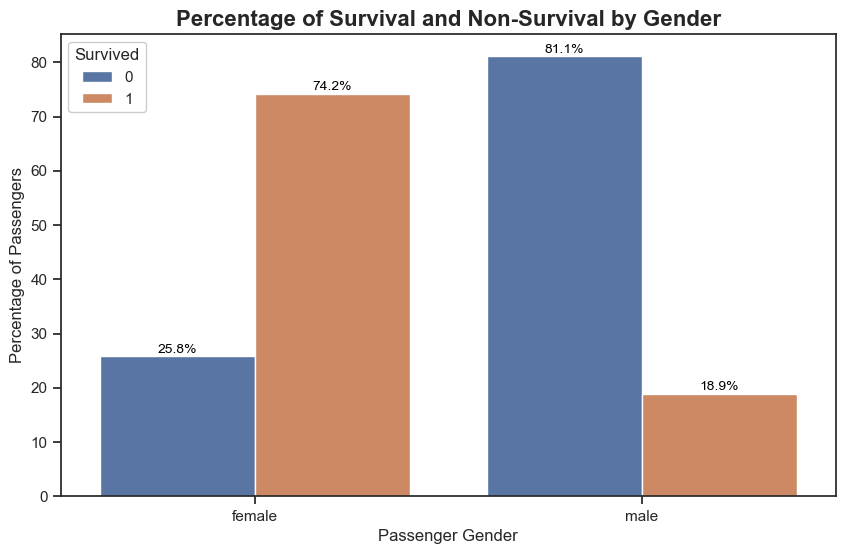

,sex,survived,count,count_total,survival_percentage
0,female,0,81,314,25.796178
1,female,1,233,314,74.203822
2,male,0,468,577,81.109185
3,male,1,109,577,18.890815


In [19]:
gr_data = DataAnalyzer.calculate_survival_percentage(train_df, 'sex')
DataAnalyzer.plot_survival_by_feature(gr_data, 'sex', 'Passenger Gender','Percentage of Passengers', 'Percentage of Survival and Non-Survival by Gender' )
gr_data

In [20]:
grouped = train_df.groupby(['sex', 'pclass', 'survived']).size().reset_index(name='count')
total_passengers = grouped.groupby('sex')['count'].sum().reset_index()
grouped = grouped.merge(total_passengers, on='sex', suffixes=('', '_total'))
grouped['survival_percentage'] = grouped['count'] / grouped['count_total'] * 100

# Filter the DataFrame for females
female_data = grouped[grouped['sex'] == 'female'].copy()

# Calculate the total number of females by class
total_females_by_class = female_data.groupby('pclass')['count'].sum().reset_index()
total_females_by_class.columns = ['pclass', 'total_females']

# Calculate the survival percentage by class for females
female_data['survival_percentage'] = female_data['count'] / total_females_by_class.merge(female_data, on='pclass')['total_females'] * 100

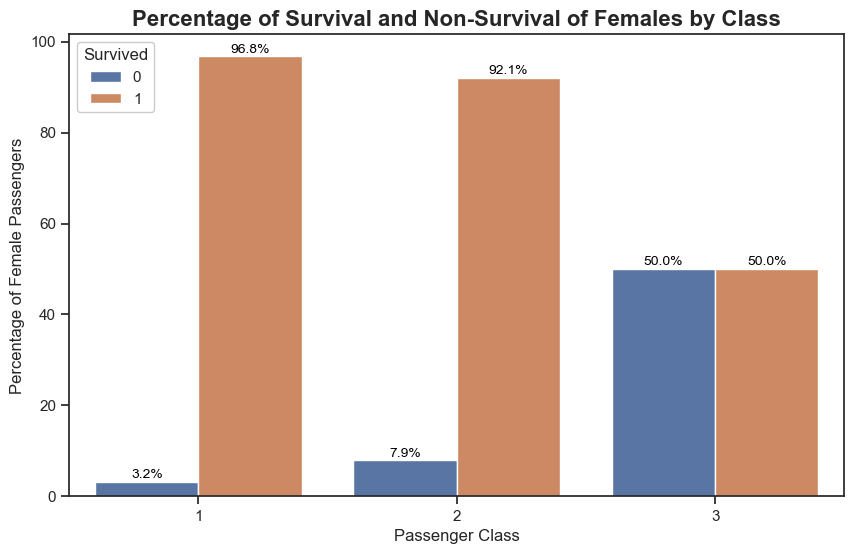

In [31]:
DataAnalyzer.plot_survival_by_feature(female_data, 'pclass', 'Passenger Class','Percentage of Female Passengers', 'Percentage of Survival and Non-Survival of Females by Class' )

- The total number of male passengers (577) significantly outweighed the number of female passengers (314). Males constituted approximately 65% of the total passengers on board.
- The survival rate for female passengers was remarkably higher than that of males. Approximately 74.2% of females survived the disaster, while only 18.9% of males managed to survive.
- Analyzing the survival rate of females based on their class of travel reveals interesting insights. First-class female passengers had an impressively high survival rate of 96.8%, followed by 92.1% for second-class passengers. These figures demonstrate that females traveling in higher classes were more likely to survive.
- In contrast, third-class female passengers experienced a significantly lower survival rate of 50%. This suggests that females in the lower class faced more challenges and had a reduced likelihood of survival.

#### **Family Size**
   - What is the distribution of family sizes (SibSp + Parch) among passengers?

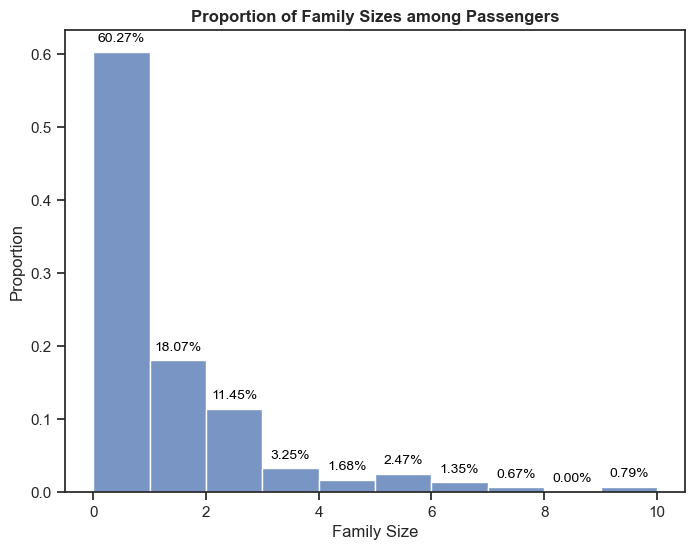

In [45]:
train_df['family_size'] = train_df['sibsp'] + train_df['parch']

plt.figure(figsize=(8, 6))
ax = sns.histplot(train_df['family_size'], bins=range(0, max(train_df['family_size']) + 1),
                 kde=False, color='#4C72B0', stat='probability')
plt.xlabel('Family Size')
plt.ylabel('Proportion')
plt.title('Proportion of Family Sizes among Passengers')

for p in ax.patches:
    proportion = p.get_height()
    ax.annotate(f'{proportion:.2%}', (p.get_x() + p.get_width() / 2., proportion), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

- Most passengers (60.27%) traveled alone or with only one family member (e.g., spouse, sibling, or parent/child). This suggests that a significant portion of passengers preferred to travel individually or with a close family member.
- The proportion of passengers with family sizes between 1 and 2 is 18.07%. This means that a considerable number of passengers traveled with a small family group, possibly with a spouse or one child.
- Approximately 11.45% of passengers had family sizes between 2 and 3. This indicates that a notable percentage of passengers traveled with a slightly larger family group, possibly with both a spouse and one or more children.
-  Only 0.79% of passengers had family sizes between 9 and 10. This suggests that a very small number of passengers were part of significantly larger family groups.



#### **Port of Embarkation**
   - How many passengers embarked from each port, and how does it relate to survival?

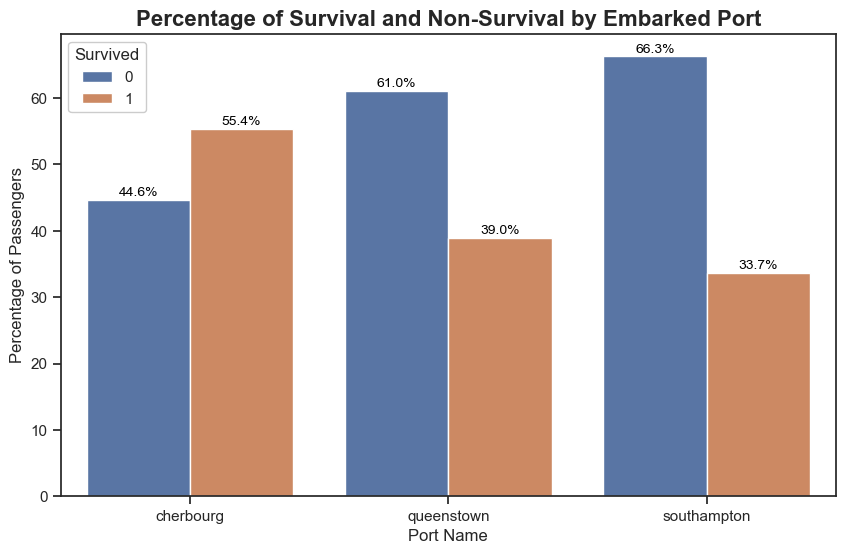

In [42]:
gr_data = DataAnalyzer.calculate_survival_percentage(train_df, 'embarked_port')
DataAnalyzer.plot_survival_by_feature(gr_data, 'embarked_port', 'Port Name','Percentage of Passengers', 'Percentage of Survival and Non-Survival by Embarked Port' )

- The majority of passengers boarded the Titanic from the Southampton port, which served as the main departure point. Among the passengers who embarked in Southampton, approximately 33.7% survived the tragic event.
- Moving on to the next highest survival rate, the passengers who boarded the Titanic in Cherbourg. These passengers exhibited a relatively higher survival rate of 55.4%.
- Lastly, passengers who embarked from Queenstown, showing a survival rate of 39%.

7. **Survival by Cabin Deck**
   - Does the deck level of the cabin influence survival rates?

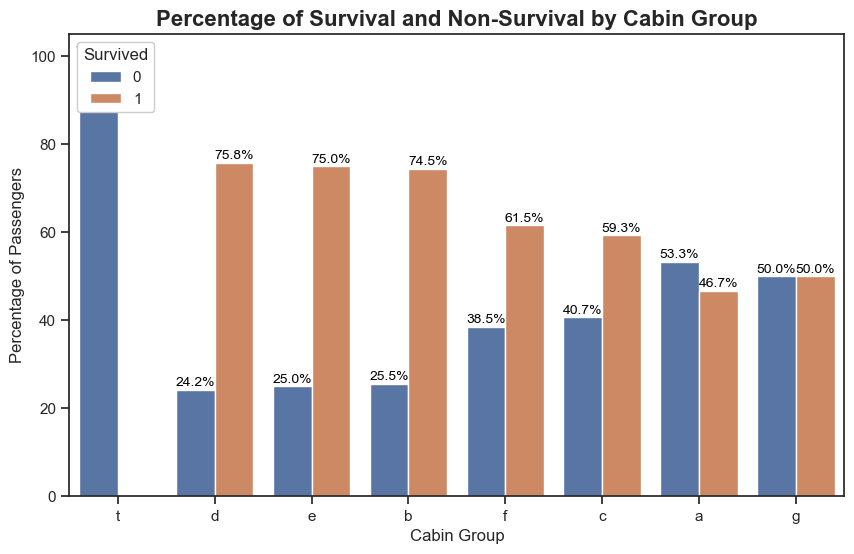

In [43]:
train_df['cabin_group'] = train_df['cabin'].str[0]
gr_data = DataAnalyzer.calculate_survival_percentage(train_df, 'cabin_group')
gr_data = gr_data.sort_values(by='survival_percentage', ascending=False)
DataAnalyzer.plot_survival_by_feature(gr_data, 'cabin_group', 'Cabin Group','Percentage of Passengers', 'Percentage of Survival and Non-Survival by Cabin Group' )

- Passengers in cabins D, E, and B demonstrated a higher likelihood of survival.
- Cabin D had the highest survival rate at 75.8%.
- Cabin E closely followed with a survival rate of 75%.
- Cabin groups A and G experienced the highest percentage of non-survivors.
- Passengers in cabin A had a non-survival rate of 53.3%.
- Passengers in cabin G had a non-survival rate of 50%.
- Interestingly, both cabin groups A and G had similar survival rates, each around 50%.
- The location of passengers within the ship, represented by their cabin groups, significantly impacted their chances of survival during the tragic event.

<a id="1.2"></a>
<h1 style="font-family: Trebuchet MS; font-size: 20px; color: #b47238; text-align: left; "><b>Fare Prediction</b></h1>

### **Fare Distribution**
   - What is the distribution of fares paid by passengers?


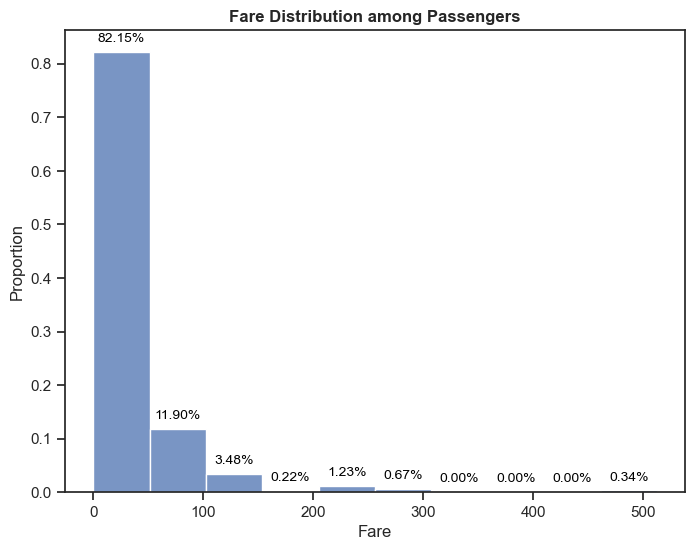

In [51]:
plt.figure(figsize=(8, 6))
ax = sns.histplot(train_df['fare'], bins=10, kde=False, color='#4C72B0', stat='probability')
plt.xlabel('Fare')
plt.ylabel('Proportion')
plt.title('Fare Distribution among Passengers')

for p in ax.patches:
    proportion = p.get_height()
    ax.annotate(f'{proportion:.2%}', (p.get_x() + p.get_width() / 2., proportion), 
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()


- The fare distribution among passengers shows that the majority (82.15%) paid fares between 0 and £50 pounds, indicating that this fare range was the most common choice.
- Around 11.90% of passengers opted for fares in the range of £50 to £100 pounds, representing a moderate fare range.
- Notably, a small proportion (1.23%) of passengers paid higher fares between £200 and £250 pounds, suggesting that only a few passengers chose this premium fare option.
- Additionally, only a very small fraction (0.34%) of passengers paid fares exceeding £500 pounds, indicating that only a handful of passengers selected the highest fare available, possibly for more luxurious accommodations or exclusive services.

### **Fare by Class**
   - How does the fare distribution vary across different passenger classes (1st, 2nd, 3rd)?

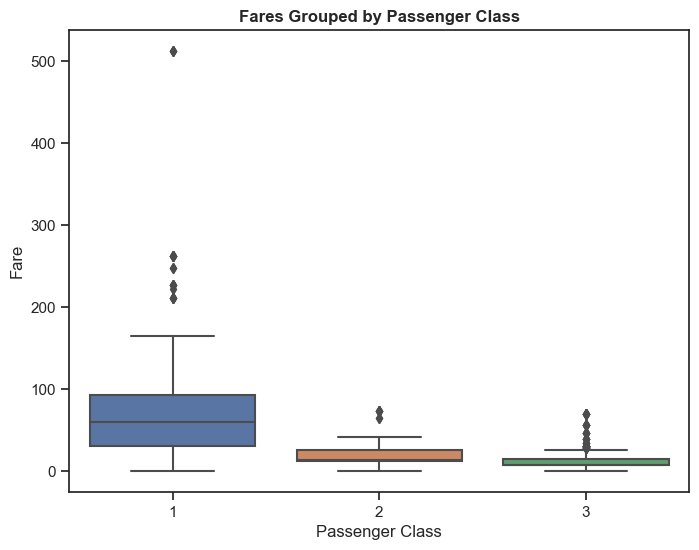

,pclass,min_fare,max_fare
0,1,0.0,262.375
1,2,0.0,73.500
2,3,0.0,69.550


In [58]:
from scipy import stats

plt.figure(figsize=(8, 6))
sns.boxplot(x='pclass', y='fare', data=train_df)
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.title('Fares Grouped by Passenger Class')
plt.show()

train_df['winsorized_fare'] = stats.mstats.winsorize(train_df['fare'], limits=[0.01, 0.01])
fare_ranges = train_df.groupby('pclass')['winsorized_fare'].agg(['min', 'max']).reset_index()
fare_ranges.columns = ['pclass', 'min_fare', 'max_fare']
fare_ranges

- The fare distribution varies among different passenger classes. For first-class passengers, the maximum fare observed was approximately £262 pounds. In contrast, second-class passengers paid a maximum fare of around £74 pounds, while third-class passengers' highest fare was approximately £70 pounds.

- Taking inflation into account, we can estimate the equivalent value of the fare paid in 1912 to today's currency. Based on the Bank of England's inflation calculator and historical inflation rates, the fare of £262 pounds in 1912 would be approximately equivalent to £24,626.21 pounds today.

<p>source: <a href="https://www.bankofengland.co.uk/monetary-policy/inflation/inflation-calculator">Bank of England's inflation calculator and historical inflation rates</a></p>

### **Fare vs. Cabin Deck**
   - Investigate if there is any correlation between the fare paid and the cabin deck assigned.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


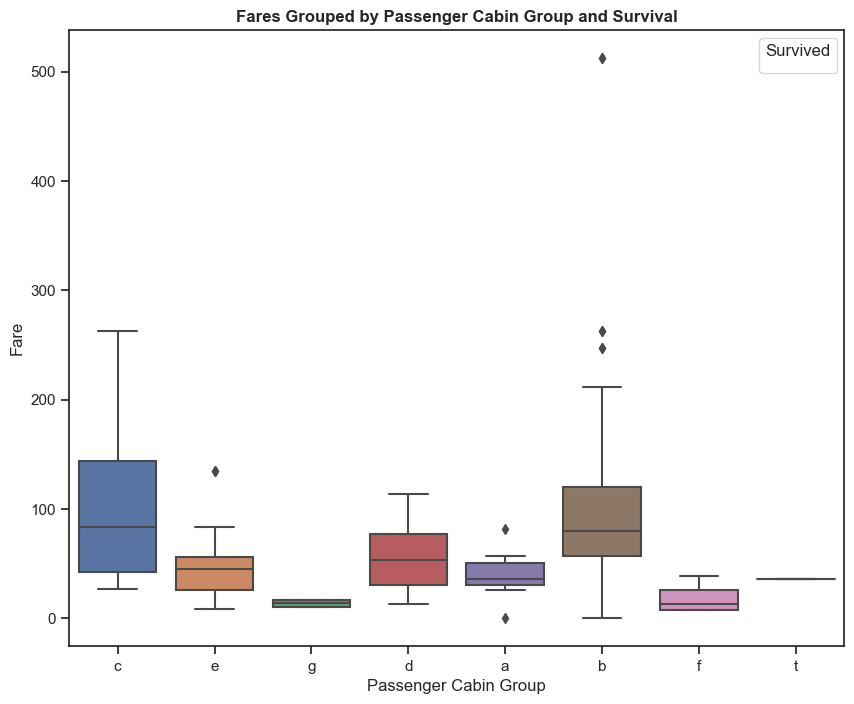

In [66]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='cabin_group', y='fare',data=train_df)
plt.xlabel('Passenger Cabin Group')
plt.ylabel('Fare')
plt.title('Fares Grouped by Passenger Cabin Group and Survival')
plt.legend(title='Survived', loc='upper right')
plt.show()

- In the previous analysys of cabins vs. survival it was found that cabins D, E and B have a higher likelihood of survival,  but those cabins groups were not the most expesnisive ones and can be seen in the in the plots. 
- Cabins Group have the higher fare rates but that are not linked directling to a higher survival rate, for example  the survival rate for cabins group C was about 59.3%. 



4. **Fare by Port of Embarkation**
   - Analyze whether the fares paid differ based on the port of embarkation.

5. **Fare by Family Size**
   - Explore how the fare amount is related to the size of the passenger's family.



In [26]:
age_by_class = train_df.groupby('pclass').age.count()
age_by_class

pclass
1    186
2    173
3    355
Name: age, dtype: int64

<AxesSubplot:xlabel='age', ylabel='class'>

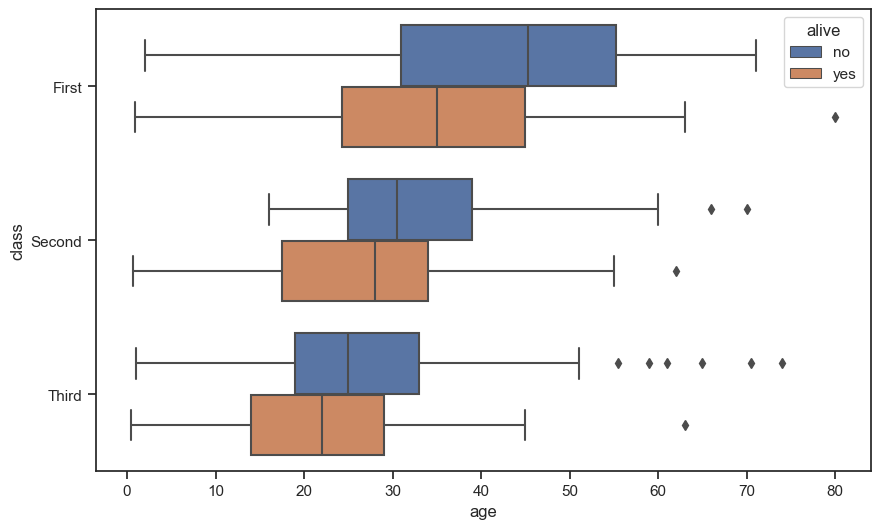

In [27]:
df = sns.load_dataset("titanic")
sns.boxplot(data=df, x="age", y="class", hue="alive")

In [28]:
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True
